<a href="https://colab.research.google.com/github/Tommmster/6620_/blob/master/CartPole_tryout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt-get install x11-utils
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install pyglet==1.5.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [4]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_display.start()
print(_display)


In [5]:
import matplotlib.pyplot as plt

# preparar el display
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()



<IPython.core.display.Javascript object>

In [6]:
import itertools
import numpy as np
import pandas as pd
from collections import defaultdict

In [19]:
class Values:
    def __init__(self, numActions, initial = 0.0):
        self.values = defaultdict(lambda : np.full(numActions, initial, dtype='float'))
        self.calls = defaultdict(lambda: 0)

    def get(self, state, action):
        self.calls[tuple(state)] += 1
        return self.values[tuple(state)][action]

    def put(self, state, action, value):
        self.values[tuple(state)][action] = value
        return self
    
    def len(self):
        return len(self.values)
        
    def argmax_for(self, state):
        return self.values[tuple(state)].argmax()

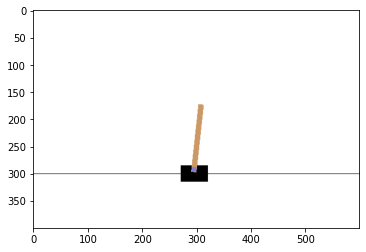

(array([-0.04008437, -0.04044573,  0.11743549,  0.22245499]), 1.0, False, {})


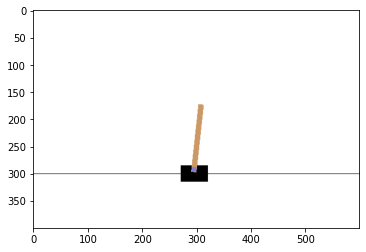

In [8]:
%matplotlib inline
import gym
import time
from IPython import display as ipythondisplay


env = gym.make('CartPole-v0')
# observation space: posición, velocidad, ángulo, velocidad de rotación

env.reset()
for i in range(20):
  screen = env.render("rgb_array")
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  result = env.step(env.action_space.sample())
  print(result)
 


In [16]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Crea una política epsilon-greedy basado en una q-función (función de valor estado-acción) y un epsilon dados.
    
    Argumentos:
        Q: un diccionario que mapea cada estado/observación s a un array de numpy Q[s] = array([v_0, v_1, ... , v_nA]) de longitud nA
        que para un índice a del array contiene el valor v_a de tomar la acción a en el estado s. 
        (en nuestra notación de la clase q(s,a))
         
        epsilon: probabilidad de seleccionar una acción aleatoria (obliga a explorar), valor entre 0 y 1.
        
        nA: número de acciones en el entorno
    
    Retorna:
        Una función que dada una observación como argumento, retorna una política (un array de numpy de longitud nA)
        con probabilidades para cada acción. La política es tal que toma la mejor acción según Q con probabilidad (1-epsilon)
        y toma una acción al azar con probabilidad epsilon 
    """
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = Q.argmax_for(observation)
        A[best_action] += (1.0 - epsilon)
        return A

    return policy_fn

def sarsa(env, num_episodes, make_Q, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Algoritmo SARSA: Control por TD (diferencias temporales) on-policy. Encuentra la política epsilon-greedy óptima.
    
    Argumentos:
        env: Ambiente de OpenAI.
        num_episodes: Número de episodios para simular.
        discount_factor: factor de descuento gama.
        alpha: factor de aprendizaje de TD.
        epsilon: Probabilidad de tomar una acción aleatoria. Entre 0 y 1.
    
    Retorna:
        Una tupla (Q, stats).
        A tuple (Q, stats).
        Q es la función de valor estado-acción óptima, un diccionario que mapea estado -> array de valores para cada acción.
        stats es un objeto EpisodeStats con dos arrays numpy para longitud de episodios y longitud de recompensas.
    """
    # La función de valor estado-acción final (q-función final)
    #  un diccionario que mapea estado -> array de valores para cada acción.
    # Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    Q = make_Q(env.action_space.n, 0.0)
    
    # la política que seguimos
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    avg_rewards = np.zeros(num_episodes)
    
    for i_episode in range(num_episodes):
        
        # Resetear el entorno y tomar primera acción
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # loop en el entorno
        for t in itertools.count():
            next_state, reward, done, _ = env.step(action)
            
            # elegir próxima acción 
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # actualizar estadísticas
            #stats.episode_rewards[i_episode] += reward
            #stats.episode_lengths[i_episode] = t
            
            # Atualización TD:
            old = Q.get(state, action)
            new = Q.get(next_state, next_action)

            old += old + alpha * (reward + epsilon * new - old)
            Q.put(next_state, next_action, old)
    
            if done:
                avg_rewards[i_episode] = t + 1
                break
                
            action = next_action
            state = next_state 
    
    return Q, None, avg_rewards

Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.

In [22]:
Q, _, _ = sarsa(env, 1000, lambda actions, i:  Values(actions, i))

Q.len()

10840